# Baskerville HPC CO2 emissions

In [1]:
!pip install -q pandas numpy matplotlib pyyaml

In [2]:
import yaml
import pandas as pd

In [3]:
def get_energy_cpu(row, cluster_info):
	"""Calculate CPU energy consumption in kWh."""
	constraints = row["Constraints"]
	if pd.isna(constraints):
		tdp_w = float(cluster_info["partitions"]["baskerville-all"]["TDP_CPU"])
	else:
		tdp_w = float(cluster_info["partitions"][f"baskerville-{constraints}"]["TDP_CPU"])
	energy_kwh = (row["Run Time (sec)"] / 3600) * row["Number of cores"] * (tdp_w / 1000) #kWh 
	return energy_kwh

def get_energy_gpu(row, cluster_info):
	"""Calculate GPU energy consumption in kWh."""
	constraints = row["Constraints"]
	if pd.isna(constraints):
		tdp_w = float(cluster_info["partitions"]["baskerville-all"]["TDP"])
	else:
		tdp_w = float(cluster_info["partitions"][f"baskerville-{constraints}"]["TDP"])
	energy_kwh = (row["Run Time (sec)"] / 3600) * row["Number of GPU"] * (tdp_w / 1000) #kWh
	return energy_kwh

def get_energy_mem(row, cluster_info):
	"""Calculate memory energy consumption in kWh."""
	power_memory_perGB=0.3725 # W/GB
	energy_kwh = (row["Run Time (sec)"] / 3600) * row["Memory (GB)"] * (power_memory_perGB / 1000) #kWh
	return energy_kwh

In [4]:
data = pd.read_csv("./data/Baskerville_total_commas.csv")
data["End Time"] = pd.to_datetime(data["End Time"])

cluster_info = yaml.safe_load(open("./data/cluster_info.yaml"))

In [5]:
data["E_cpu"] = data.apply(axis=1, func=get_energy_cpu, cluster_info=cluster_info) 
data["E_gpu"] = data.apply(axis=1, func=get_energy_gpu, cluster_info=cluster_info)
data["E_mem"] = data.apply(axis=1, func=get_energy_mem, cluster_info=cluster_info)
data["E_total_compute"] = data["E_cpu"] + data["E_gpu"] + data["E_mem"]

data["E_total"] = data["E_total_compute"] * cluster_info["PUE"] # PUE is ratio, still in kWh
data["CO2_total_g"] = data["E_total"] * cluster_info["CI"] # CI is 125 gCO₂/kWh, output is gCO₂

In [6]:
print("All time CO2 emissions (Scope 2):", data["CO2_total_g"].sum() / 1e6, "tonnes") # in tonnes CO2

All time CO2 emissions (Scope 2): 37.19099675047847 tonnes


For comparison:
- The average yearly CO2 emissions for one person in the UK is 4.4 tonnes[1].
- One flight from Paris to London is about 50 kgCO2e (0.05 tonnes)[2].
- One flight from New York to San Francisco is about 570 kgCO2e (0.57 tonnes)[2].
- One flight from New York to Melbourne is about 2 310 kgCO2e (2.31 tonnes)[2].

1. https://ourworldindata.org/co2/country/united-kingdom
2. https://advanced.onlinelibrary.wiley.com/doi/10.1002/advs.202100707

In [7]:
data["YYYY-MM"] = data["End Time"].apply(lambda x: x.strftime("%Y-%m"))
data["YYYY"] = data["End Time"].apply(lambda x: x.strftime("%Y"))

<Axes: title={'center': 'Baskerville Monthly Emissions'}, xlabel='Month', ylabel='tonnes CO2e'>

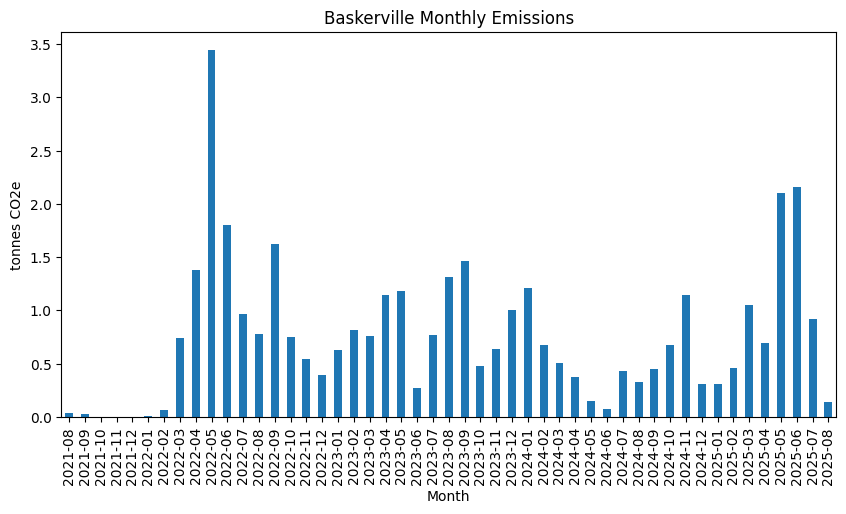

In [ ]:
data.groupby("YYYY-MM")["CO2_total_g"].sum().apply(lambda x: x / 1e6).plot(
    kind="bar", 
    title="Baskerville Monthly Emissions", 
    ylabel="tonnes CO2e", 
    xlabel="Month", 
    figsize=(10,5)
)

In [9]:
data.groupby("YYYY")["CO2_total_g"].sum() / 1e6 # in tonnes CO2

YYYY
2021     0.069219
2022    12.488527
2023    10.472155
2024     6.325650
2025     7.835446
Name: CO2_total_g, dtype: float64

i.e. In 2025, we emitted ~1.7 UK persons worth of CO2, ~14 flights from New York to San Francisco or ~3 flights from New York to Melbourne.

<Axes: title={'center': 'Baskerville Yearly Emissions'}, xlabel='Year', ylabel='tonnes CO2e'>

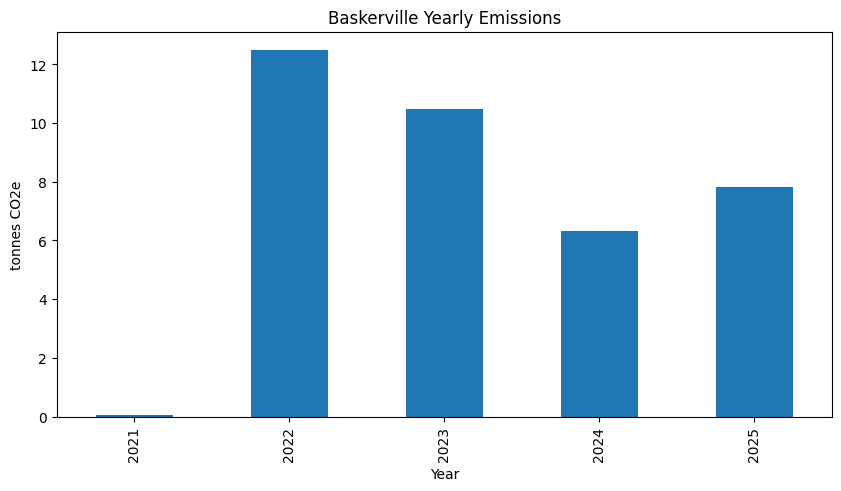

In [11]:
data.groupby("YYYY")["CO2_total_g"].sum().apply(lambda x: x/1e6).plot(
    kind="bar", 
    title="Baskerville Yearly Emissions", 
    ylabel="tonnes CO2e", 
    xlabel="Year", 
    figsize=(10,5)
)